In [1]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
import pandas as pd
import os
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('whitegrid')
import re
from datetime import datetime
from IPython.display import clear_output

In [101]:
class link_scraper():
    def __init__(self, headless=True):
        options = Options()
        if headless: options.add_argument("--headless")
        self.driver = webdriver.Firefox(options=options)
        self.transfer_df = pd.DataFrame()
    
    def parse_odds(self,odds_val):
        odds_str = str(odds_val)
        if '/' in odds_str:
            num, denom = odds_str.split('/')
            return int(num) / int(denom)
        else:
            try:
                return float(odds_str)
            except:
                return np.nan
    
    def parse_link(self, link):
        self.driver.get(link)
        tables = pd.read_html(self.driver.page_source)
        # Odds table seems to be last table on page
        odds_df = tables[-1]
        # Remove crazy long column names
        odds_df.columns = [''] * len(odds_df.columns)
        # Transpose - clubs along axis
        clean_df = odds_df.T.rename(columns=odds_df.T.iloc[0])
        # Calculate lowest odds - most likely
        long_df = pd.DataFrame(clean_df.applymap(self.parse_odds).min()).reset_index()
        # Add in column names, including player name
        long_df.columns = ['destination', 'odds']
        long_df['player'] = link.split('/')[-2].replace('-',' ').title()
        # add probability and date
        long_df['probability'] = 1 / (1 + long_df['odds'])
        long_df['date'] = datetime.now().date()
        self.transfer_df = self.transfer_df.append(long_df, sort=False)
        
    def get_links(self):
        url = 'https://www.oddschecker.com/football/football-specials'
        self.driver.get(url)
        sleep(1)
        #Sometimes there is annoying popup
        try:
            driver.find_element_by_xpath('//*[@id="promo-modal"]/div[1]/div/div/div[5]/a').click()
        except:
            pass
        sleep(1)
        #Find the transfer rumours
        fixtures = self.driver.find_element_by_xpath('//*[@id="outrights"]/div/ul')
        markets = fixtures.find_elements_by_tag_name('li')
        links = [m.find_element_by_tag_name('a').get_attribute('href') for m in markets]
        self.transfer_links = [l for l in links if  'club-after-summer-transfer-window' in l]
        
    def parse_all_links(self):
        try:
            self.get_links()
            for i, l in enumerate(self.transfer_links):
                clear_output()
                print(f'{l} \n')
                print(f'{i+1}/{len(self.transfer_links)} \n')
                sleep(1)
                self.parse_link(l)
                # Append to df
            self.driver.quit()
            return self.transfer_df
        except Exception as e:
            self.driver.quit()
            raise e

In [102]:
ls = link_scraper()

In [ ]:
combined_df = ls.parse_all_links()

https://www.oddschecker.com/football/player-specials/philippe-coutinho/club-after-summer-transfer-window

63/85



## Plotting

plotting functions, by club and by player

In [96]:
def make_bar_chart(df,filter_val,y_val ,val, title ,show_flag=False):
    player_df = df.loc[(df[filter_val]==val) &
                             (df.probability > 0)].sort_values(by='probability',ascending=False)
    if player_df.shape[0] > 2:
        plt.subplots(figsize=(20,15))
        ax = sns.barplot(data=player_df,y=y_val,x='probability',orient='h')
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=90)
        ax.set_title(title,{'fontsize':20})
        plt.savefig(f'output/{filter_val}s/{val}.png')
        if show_flag: plt.show()
        plt.close()

In [97]:
!rm -rf output/players
!rm -rf output/destinations
!mkdir output/players
!mkdir output/destinations

In [98]:
for dest in combined_df.loc[~combined_df.destination.str.contains('To Stay|To Leave|Any')
                            ,'destination'].unique():
    make_bar_chart(df=combined_df,
                   filter_val='destination',
                   y_val='player',
                   val=dest,
                   title=f'{dest} Transfer Targets \n')

In [99]:
for player in combined_df.player.unique():
     make_bar_chart(df=combined_df,
                   filter_val='player',
                   y_val='destination',
                   val=player,
                   title=f'{player} Destinations \n')

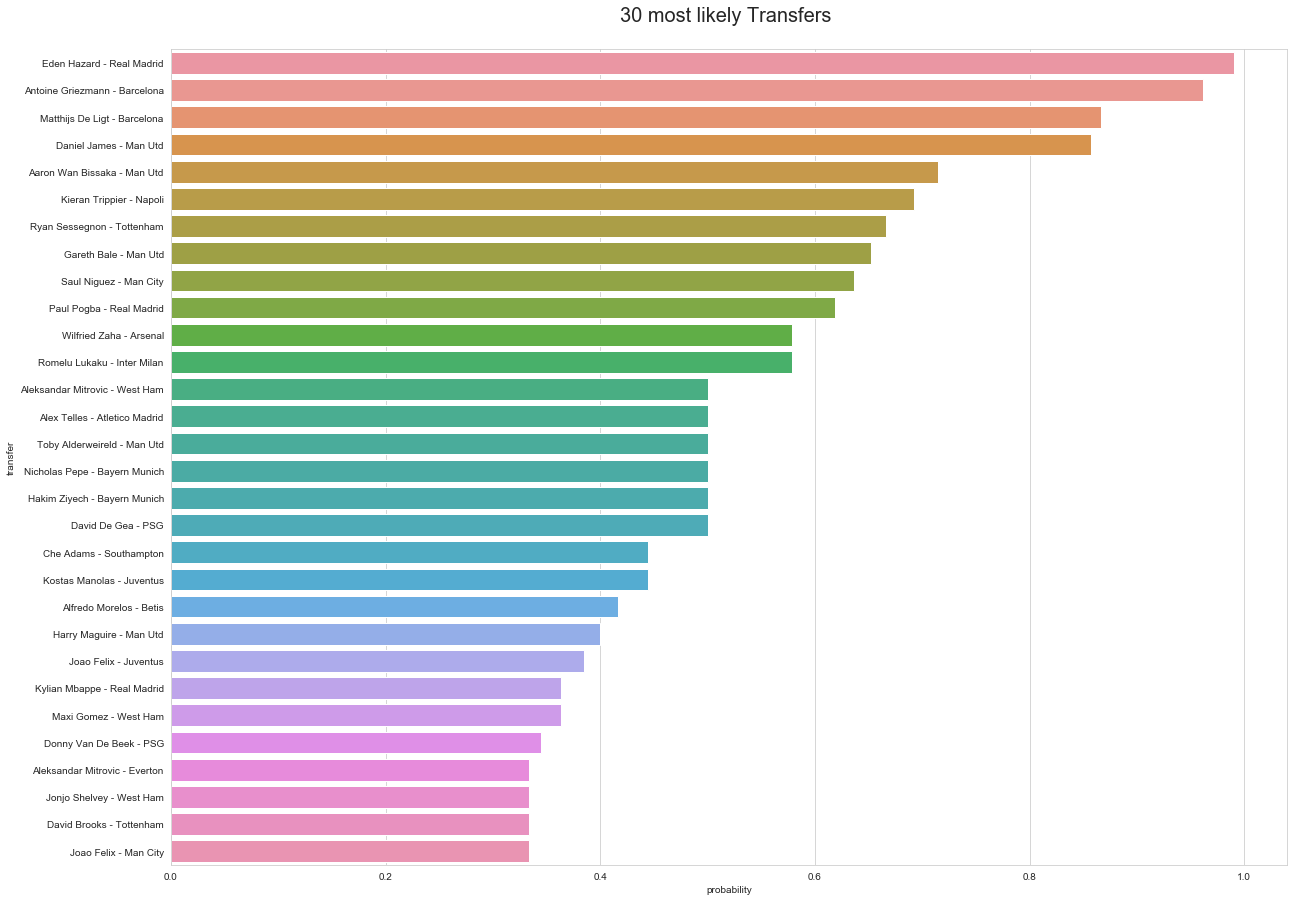

In [100]:
def plot_most_likely(df, n):
    most_likely = (combined_df
                   .loc[~combined_df.destination.str.contains('To Stay|To Leave|Any')]
                   .sort_values(by='probability',ascending=False)
                   .head(n))
    most_likely['transfer'] = most_likely.player + ' - ' + most_likely['destination']
    plt.subplots(figsize=(20,15))
    ax = sns.barplot(data=most_likely,y='transfer',x='probability',orient='h')
    ax.set_title(f'{n} most likely Transfers \n',{'fontsize':20})
    plt.savefig(f'output/{n} most likely overall.png')
    
plot_most_likely(combined_df, 30)

In [ ]:
combined_df.to_csv(f'output/data/{datetime.now().date()}.csv')

In [ ]:
print(datetime.now())

In [94]:
combined_df.shape

(914, 5)